# Vector bosons

Vector bosons $1^{-}$ are characterized by an angular distribution in the coordinate space $\theta \in [0, \pi], \phi \in [0, 2\pi]$ which has the following expression:


$$  F(\theta, \phi) = \frac{3}{4\pi} \left[ \frac{1}{2}(1-\alpha) + \frac{1}{2}(3\alpha -1)\cos^2(\theta) - \beta \sin^2(\theta)\cos(2\phi) - \sqrt{2}\gamma \sin(2\theta)\cos(\phi) \right]$$

The model parameters are theoretically fixed at the following values:
$$ \alpha=0.65 \quad,\quad \beta=0.06 \quad,\quad  \gamma=−0.18$$

Generate 100.000  Monte Carlo events distributed according to the previous law and perform the following exercises:

- Determine the values of $\alpha, \beta, \gamma$ with the extended maximum likelihood method.
- Test the Central Limit Theorem repeating $N=1000$ experiments each of $n=50000$ events
- Make an hypothesis test using the Likelihood ratio against a uniform distribution ($0^{-}$)

In [6]:
%config InlineBackend.figure_formats = ['svg']
from iminuit import cost, Minuit
import math as mt
import numpy as np
from random import uniform
import matplotlib.pyplot as plt
from iminuit import Minuit

We are not sure this is a pdf, it is just a distribution, let's compute its integral via Monte Carlo integration and in case define a pdf by renormalizing with the integral value

$$ \frac{Volume}{n} \sum_{i=1}^{n} f(x_i) \xrightarrow[]{n\rightarrow \infty} \int_{\Omega} f(x)dx $$

In [4]:
def distribution(theta:np.array , phi:np.array, alpha:float=0.65, beta:float=0.06, gamma:float=-0.18) -> np.array :
    return ((3./(4*mt.pi)) * (0.5*(1-alpha) + 0.5*(3*alpha - 1)*np.pow(np.cos(theta), 2) - 
                              0.06*np.pow(np.sin(theta), 2)*np.cos(2*phi) - 
                              mt.sqrt(2)*(-0.18)*np.sin(2*theta)*np.cos(phi)))

In [11]:
# let's throw n__ random events in the theta and phi dominium and evaluate the distribution 

n__ = 100000

#define the range
theta_range = (0, mt.pi)
phi_range = (0, 2*mt.pi)

# [[0, pi], [0.1, 0.01], ...]
rand_sequence = np.array([[uniform(*theta_range), uniform(*phi_range)] for _ in range(int(n__))])

theta = rand_sequence[:,0]
phi = rand_sequence[:,1]

func = distribution(theta, phi)

volume = (theta_range[1] - theta_range[0]) * (phi_range[1] - phi_range[0])

integral = volume / n__ * np.sum(func)

print(f"The integral of the distribution is {integral}")

The integral of the distribution is 1.9452256844049474


So we found that indeed this is not a real pdf. To obtain one we simply scale the overall function by the distribution integral of about $1.944$ (it will change because of random numbers!).

We then procees to generate random events (ora pairs of $\theta$ and $\phi$ values) distributed according to the vector boson $1^{-}$ pdf. To do that we generate three uniformly distributed values for 
$$ \theta, \phi, F_{unif}$$
We then evaluate $F(\theta, \phi)$ and if $F_{unif} < F(\theta, \phi)$ then we retain the $\theta, \phi$ pair otherwise we throw it away

In [27]:
def pdf(theta_phi, N, alpha:float=0.65, beta:float=0.06, gamma:float=-0.18):
    theta, phi = theta_phi
    # 1.94547724077548 normalization factor for pdf
    return N* (1./1.9452256844049474) * ((3./(4*mt.pi)) * (0.5*(1-alpha) + 0.5*(3*alpha - 1)*np.pow(np.cos(theta), 2) - beta*np.pow(np.sin(theta), 2)*np.cos(2*phi) - mt.sqrt(2)*gamma*np.sin(2*theta)*np.cos(phi)))

In [28]:
n__ = 100000

# then compute the rand
rand_sequence = np.array([[uniform(0, mt.pi), uniform(0, 2*mt.pi), uniform(0.0, 1.0)] for _ in range(int(n__))])

theta = rand_sequence[:,0]
phi = rand_sequence[:,1]
pdf_rand = rand_sequence[:,2]
pdf_eval = pdf((theta, phi), N=1)
stacked = np.stack((theta, phi, pdf_rand, pdf_eval)).T

catch = stacked[stacked[:,2] <= stacked[:,3]]

Text(0, 0.5, '$\\phi$')

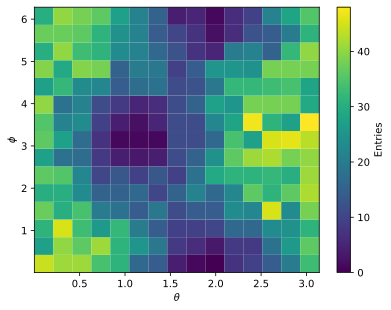

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
h = ax.hist2d(catch[:,0], catch[:,1], bins=[15,15])
plt.colorbar(h[3], ax=ax, label="Entries")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi$")

Let's also derive the empirical cumulative distribution function, that we can obtain by manually integrating the 2d distribution as we do not have the analytical form for the cdf

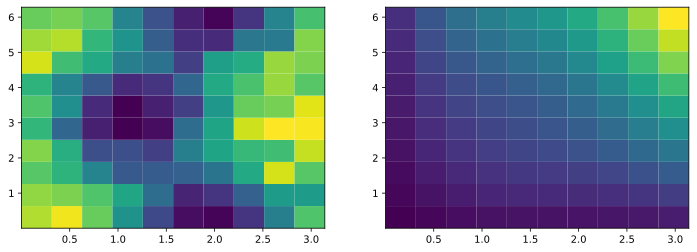

In [30]:
n2, xe, ye = np.histogram2d(catch[:,0], catch[:,1], bins=(10, 10))

dx = xe[1] - xe[0]
dy = ye[1] - ye[0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
ax1.pcolormesh(xe, ye, n2.T)

cdf = n2.cumsum(axis=0).cumsum(axis=1)*dx*dy

ax2.pcolormesh(xe, ye, cdf.T)
plt.show()

Let's now fit the obtained counts with the extended maximum likelihood method. To do so we need the IMinuit package

In [31]:
c = cost.ExtendedBinnedNLL(n2, (xe, ye), pdf, use_pdf="approximate")
m = Minuit(c, N=catch.shape[0], alpha=0.65, beta=0.06, gamma=-0.18)
m.limits["alpha", "beta", "N"] = (0.0001, None)
m.limits["gamma"] = (-1.0, 0.0)

m.migrad(ncall=100000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.78 (χ²/ndof = 0.9)      │              Nfcn = 76               │
│ EDM = 1.47e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  5.18e3   │  0.08e3   │            │            │ 0.0001  │         │       │
│ 1 │ alpha │   0.624   │   0.011   │            │            │ 0.0001  │         │       │
│ 2 │ beta  │   0.060   │   0.009   │            │            │ 0.0001  │         │       │
│ 3 │ gamma │  -0.180   │   0.006   │            │            │   -1    │    0    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────┐
│       │          N      alpha       beta      gamma │
├───────┼─────────────────────────────────────────────┤
│     N │   6.48e+03 -378.12e-3   74.16e-3    9.22e-3 │
│ alpha │ -378.12e-3   0.000119   -0.02e-3         -0 │
│  beta │   74.16e-3   -0.02e-3   8.47e-05    0.03e-3 │
│ gamma │    9.22e-3         -0    0.03e-3   3.91e-05 │
└───────┴─────────────────────────────────────────────┘

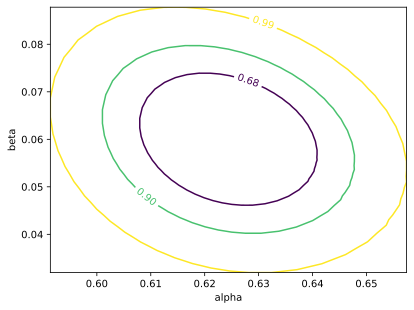

In [32]:
m.draw_mncontour("alpha", "beta", cl=(0.68, 0.9, 0.99));

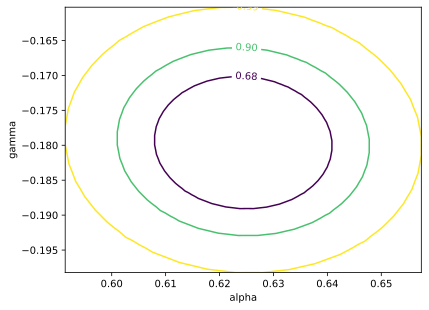

In [33]:
m.draw_mncontour("alpha", "gamma", cl=(0.68, 0.9, 0.99));

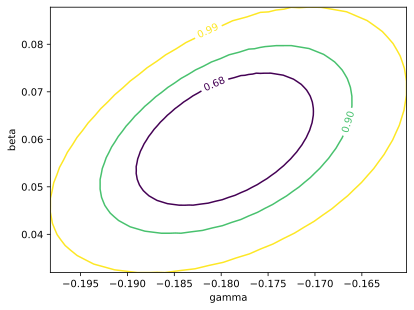

In [34]:
m.draw_mncontour("gamma", "beta", cl=(0.68, 0.9, 0.99));

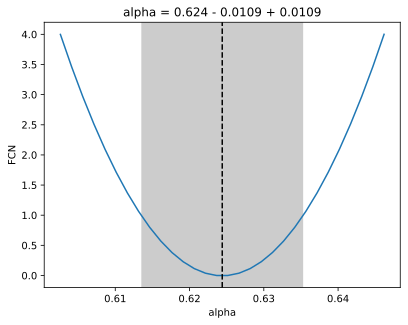

In [35]:
m.draw_mnprofile("alpha");

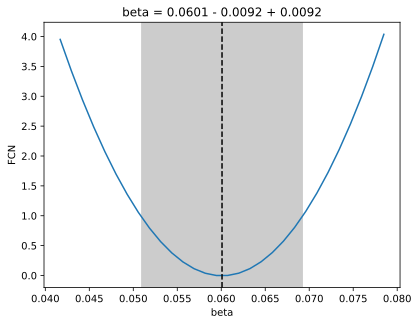

In [36]:
m.draw_mnprofile("beta");

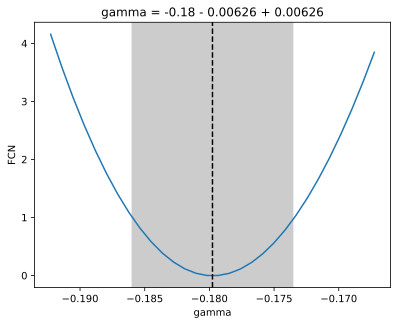

In [37]:
m.draw_mnprofile("gamma");

# CLT Test

Lets now test the CLT by repeating the fitting procedure 1000 times and retrieving the values of the fit parameters

In [50]:
alphas__ = []
betas__ = []
gammas__ = []

for _ in range(1000):

    n__ = 50000
    rand_sequence = np.array([[uniform(0, mt.pi), uniform(0, 2*mt.pi), uniform(0.0, 1.0)] for _ in range(int(n__))])
    
    theta = rand_sequence[:,0]
    phi = rand_sequence[:,1]
    pdf_rand = rand_sequence[:,2]
    pdf_eval = pdf((theta, phi), N=1)
    stacked = np.stack((theta, phi, pdf_rand, pdf_eval)).T
    
    catch = stacked[stacked[:,2] <= stacked[:,3]]

    n2, xe, ye = np.histogram2d(catch[:,0], catch[:,1], bins=(10, 10))

    c = cost.ExtendedBinnedNLL(n2, (xe, ye), pdf, use_pdf="approximate")
    m = Minuit(c, N=catch.shape[0], alpha=0.65, beta=0.06, gamma=-0.18)
    m.limits["alpha", "beta", "N"] = (0.0001, None)
    m.limits["gamma"] = (-1.0, 0.0)
    
    m.migrad(ncall=100000)

    alphas__.append(m.params["alpha"].value)
    betas__.append(m.params["beta"].value)
    gammas__.append(m.params["gamma"].value)

Let's fit the distributions of the best-fit parameters and see whether they are indeed normal as stated by the CLT

In [61]:
from scipy.stats import norm
from iminuit.cost import UnbinnedNLL

def pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

# Negative unbinned log-likelihood, you can write your own
cost = UnbinnedNLL(alphas__, pdf)

m = Minuit(cost, mu=0, sigma=1)
m.limits["sigma"] = (0, np.inf)
m.migrad()  # find minimum
m.hesse()   # compute uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5504                      │              Nfcn = 95               │
│ EDM = 4.51e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │ 644.5e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ sigma │ 15.44e-3  │  0.34e-3  │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 2.38e-07        0 │
│ sigma │        0 1.19e-07 │
└───────┴───────────────────┘

In [62]:
print(fr"CLT best fit estimate for alpha: {m.params["mu"].value} +- {m.params["sigma"].value} ")

CLT best fit estimate for alpha: 0.6445388825312558 +- 0.015439173649820503 


In [63]:
cost = UnbinnedNLL(betas__, pdf)

m = Minuit(cost, mu=0, sigma=1)
m.limits["sigma"] = (0, np.inf)
m.migrad()  # find minimum
m.hesse()   # compute uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -5667                      │              Nfcn = 148              │
│ EDM = 1.29e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  55.0e-3  │  0.5e-3   │            │            │         │         │       │
│ 1 │ sigma │ 14.23e-3  │  0.32e-3  │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 2.02e-07        0 │
│ sigma │        0 1.01e-07 │
└───────┴───────────────────┘

In [64]:
print(fr"CLT best fit estimate for beta: {m.params["mu"].value} +- {m.params["sigma"].value} ")

CLT best fit estimate for beta: 0.05502294702064426 +- 0.014229360118624745 


In [65]:
cost = UnbinnedNLL(gammas__, pdf)

m = Minuit(cost, mu=0, sigma=1)
m.limits["sigma"] = (0, np.inf)
m.migrad()  # find minimum
m.hesse()   # compute uncertainties

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -6484                      │              Nfcn = 123              │
│ EDM = 3.24e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │-174.22e-3 │  0.30e-3  │            │            │         │         │       │
│ 1 │ sigma │  9.46e-3  │  0.21e-3  │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 8.94e-08        0 │
│ sigma │        0 4.47e-08 │
└───────┴───────────────────┘

In [66]:
print(fr"CLT best fit estimate for gamma: {m.params["mu"].value} +- {m.params["sigma"].value} ")

CLT best fit estimate for gamma: -0.17422239115023114 +- 0.009457541007959147 


Text(0, 0.5, 'MLE - True')

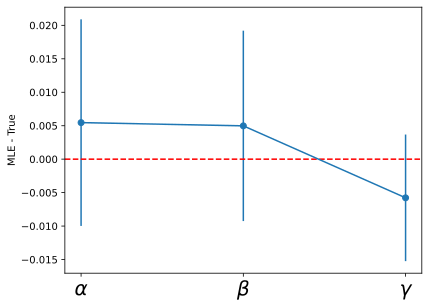

In [83]:
xs = [0,1,2]
ys = [0.65 - 0.6445388825312558, 0.06 - 0.05502294702064426, -0.18 -(-0.17422239115023114)]

yerrs = [0.015439173649820503, 0.014229360118624745, 0.009457541007959147]
xerrs = [0, 0, 0]

plt.errorbar(xs, ys, xerr=xerrs, yerr=yerrs, marker='o')
plt.xticks([0, 1, 2], labels=[r"$\alpha$", r"$\beta$", r"$\gamma$"], fontsize=20)
plt.axhline(y=0, color = 'r', linestyle = '--')
plt.ylabel("MLE - True")